<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/getting_stac_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook demonstrates how to query Open Street Maps for National Forest Boundaries and Planetary Computer's data catalog for seamless elevation and Sentinel 2 level 2a processed data.

Author John Hogland 12/1/2023

## Install various packages

In [1]:
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install osmnx
!pip install raster_tools
!pip install pystac_client
!pip install stackstac
!pip install planetary_computer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.

## Import packages

In [2]:
from raster_tools import Raster, clipping
import numpy as np, geopandas as gpd, pandas as pd, osmnx as ox

## Get forest boundary and buffered extent to download elevation and Sentinel 2 Level 2a processed imagery using Open Street Maps

In [13]:
snf=ox.geocode_to_gdf('Malheur National Forest, OR, USA') # can change to any forest (used to create a geometry for selecting the extent of the study area)
ply=snf.buffer(0.25)
geo=ply[0]

<ipython-input-13-8ea3fbe9d177>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ply=snf.buffer(0.25)


## Import packages and make methods to download and mosaic stac data

In [14]:
import pystac_client
import stackstac
import planetary_computer

def make_mosaic(xra):
    return Raster(stackstac.mosaic(xra))

def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="3dep-seamless",qry=None,res=None,crs=5070,dt=None,limit=1000):
    '''
    gets data from planetary computer

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer
    name = (string) catelog resource
    qry =  (dictoinary) of property values
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (strin) data time intervale 2022/2023
    limit = (int) max number of items to return

  returns (stac items, dataframe of tiles, and xarray data array)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, query=qry, datetime=dt, limit=limit,)
    ic = srch.item_collection()
    df = gpd.GeoDataFrame.from_features(ic.to_dict(), crs="epsg:4326")
    xra = stackstac.stack(ic,resolution=res,epsg=crs)
    return ic, df, xra


## Get 3dep seamless 30 meter resolution elevation data

In [15]:
url="https://planetarycomputer.microsoft.com/api/stac/v1" #planetary computer url
nm="3dep-seamless" #specify the catalog name
qry={'gsd':{'eq':30}} #query for 30 meter data
ic,df,xra = get_stac_data(geo,url,nm,qry,(30,30),5070) #get the data
dem=make_mosaic(xra) #make a mosaic of the surfaces

/usr/local/lib/python3.10/dist-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


## Visualize the boundary of each dem tile and plot a subset of the boundary


In [16]:
m=df.explore(style_kwds={"fillOpacity":0})
m=snf.explore(m=m,color='orange')
m

### Clip elevation to national forest boundary and plot (note, only pixels for the extent of the national forest are downloaded when plotting)

/usr/local/lib/python3.10/dist-packages/rasterio/features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


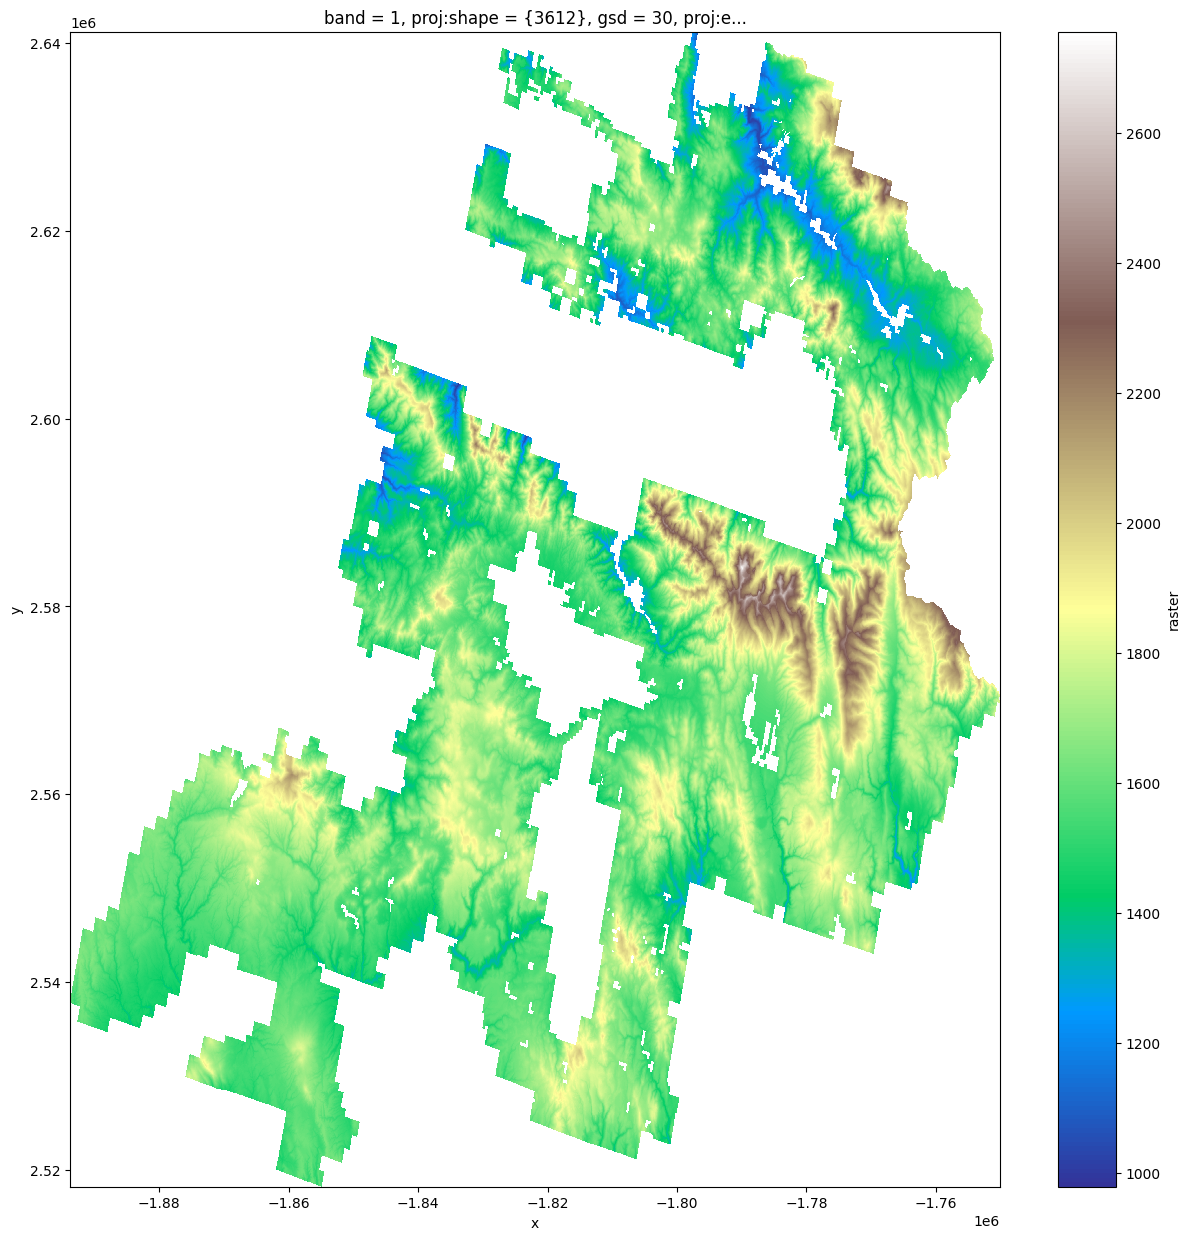

In [17]:
snf_p=snf.to_crs(dem.crs)
dem_c=clipping.clip(snf_p,dem)
dem_c.plot(figsize=(15,15),cmap='terrain')

## Get Sentinel 2 level 2a processed data for the extent of the boundary and the month of June 2022

In [18]:
nm='sentinel-2-l2a'
qry={'eo:cloud_cover':{'lt':1}}
dt='2022-06'
ic,df,xra = get_stac_data(geo,url,nm,qry,(10,10),5070,dt)

## Visualize the various scenes and project area

In [19]:
m=df.explore(style_kwds={"fillOpacity":0})
m=snf.explore(m=m,color='orange')
m

## Look at the xarray data array. Any attribute or coordiante variable can be used to subset the array.

In [20]:
xra

<xarray.DataArray 'stackstac-3232ce017621e454a4ffca5444eb57c1' (time: 16,
                                                                band: 17,
                                                                y: 36630,
                                                                x: 33505)>
dask.array<fetch_raster_window, shape=(16, 17, 36630, 33505), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-06-15...
    id                                       (time) <U54 'S2B_MSIL2A_20220615...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 -1.962e+06 ... -1.62...
  * y                                        (y) float64 2.802e+06 ... 2.436e+06
    s2:mean_solar_zenith                     (time) float64 24.98 22.8 ... 25.18
    ...                                       ...
    gsd                                      (band) object 10.0 60.0 ... None
    title                                    (band) <U37 'Aerosol optical thi...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(-1961960, 2436050, -1626910, 2...
    crs:         epsg:5070
    transform:   | 10.00, 0.00,-1961960.00|\n| 0.00,-10.00, 2802350.00|\n| 0....
    resolution:  10

## Extract band BO2 (blue) and mosaic the various scenes dates to produce a 1 band raster. One could do various things here to subset the data and produce a seamless raster, but we are going to simply mosaic based on the order of rasters in the item collections.

In [21]:
xra2=xra.sel(band='B02')
sent2=make_mosaic(xra2)
sent2.xdata

<xarray.DataArray 'raster' (band: 1, y: 36630, x: 33505)>
dask.array<where, shape=(1, 36630, 33505), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * band                                     (band) int64 1
  * x                                        (x) float64 -1.962e+06 ... -1.62...
  * y                                        (y) float64 2.802e+06 ... 2.436e+06
    sat:orbit_state                          <U10 'descending'
    s2:processing_baseline                   <U5 '04.00'
    instruments                              <U3 'msi'
    ...                                       ...
    title                                    <U37 'Band 2 - Blue - 10m'
    common_name                              object 'blue'
    center_wavelength                        object 0.49
    full_width_half_max                      object 0.098
    epsg                                     int64 5070
    spatial_ref                              int64 0
Attributes:
    _FillValue:  -999999.0

## Take a subset of the image and plot it

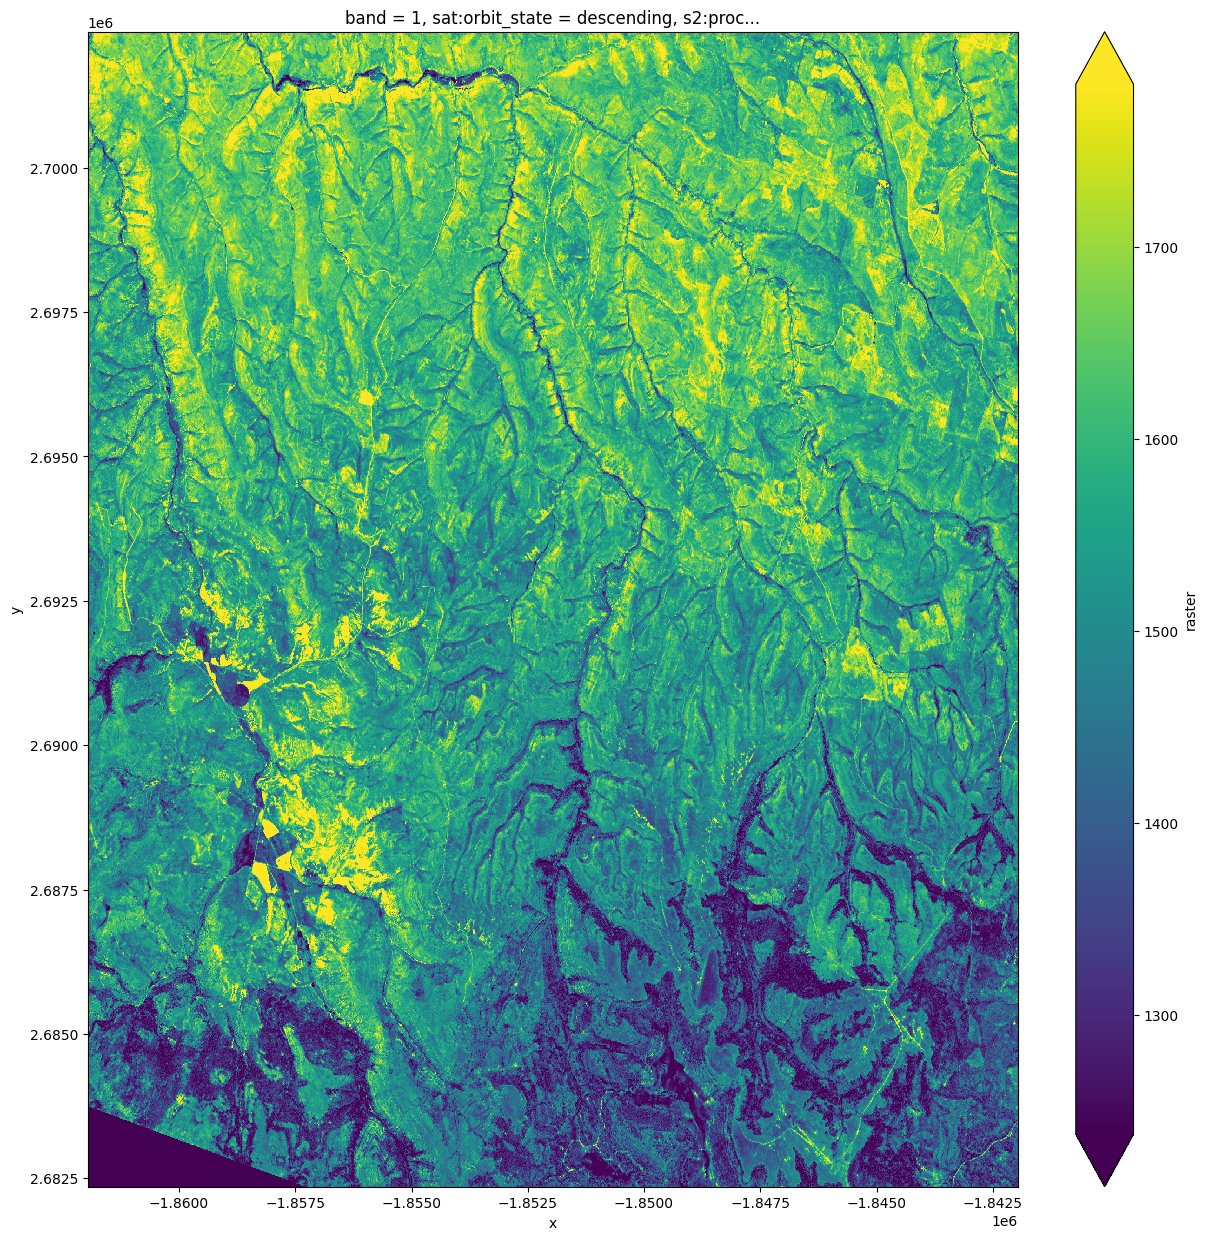

In [22]:
(sent2.xdata[0,10000:12000,10000:12000]).plot(figsize=(15,15),robust=True) #only band 2 pixels for the extent of the national forst are downloaded